# Proof of concept: dvmdostem input data compression
Working to see if we can leverage inherent NetCDF compression to 
handle the problem of supporting runs of spatially discontiguous 
gridcells while maintaing a CF-standards compliant netcdf file.

A single climate driver variable for dvmdostem, over the whole AIEM 
domain for 200 years at 1km spatial resolution and 1 monthly 
time resolution take ~40GB per variable:

----------------
    1850*2560 = 4,736,000 pixels in AIEM domain, including oceans, etc.

    4 bytes
    ----------- * 12 months * 200 years * (1850*2560) = 45,465,600,000 bytes
    32bit float

    45,465,600,000 / 1024 / 1024 / 1024 = 42.34 GB
-----------------

With the original input scheme, we can reduce this by roughly half by
storing the information by ID and lookup and discarding all the cells
that are over oceans, mountains etc. This reduces the valid pixel count
in the AIEM domain to ~2,169,672 pixels, and the final size to ~19.4GB for 
each driving variable. Thus as of 12/4/2014, when looking at the input data
on `atlas:/big_scratch/tem/CLIMATE` we see sizes of ~45GB for the files that
contain 4 driving variables and 100 years:

-----------------
    tcarman2@atlas $ ls -alh echam5*
    36G Aug 11 10:23 echam5_a1b_climate_2010-2100.nc
    45G Aug 21 10:41 echam5_a2_climate_2010-2100.nc
    45G Aug 21 11:16 echam5_B1_climate_2010-2100.nc
-----------------

In order to support runs of "spatially non-contiguous grid cells" while avoiding
a custom indexed file format, we are investigating the possibility of leveraging 
the compression that is built into NetCDF. For this we'd like to see how compressesd 
a `.nc` file is when we mask out a whole bunch of data.

For a proof of concept we describe here the method we used to create 
a sample dataset with timeseries data for a non-rectangular selection
of grid cells - for example "tempertature data for 100 years for all 1km 
cells in the AIEM domain that are vegetation type 4".

The process will be:
1. Setup: Download data, load libraries, etc.

1. Create a mask for a certain vegetation type from a `.tif` 
with landcover information.

1. Test the mask by applying it to a set of temperature data and
visually confirming that the data selection looks appropriate.

1. Build a netcdf file by applying the mask to a set of `.tifs` 
with temperature data for a given number of years and appending 
the selected data to the `.nc` file.

1. Attempt to compress the resutling netcdf file.


## Setup

Load up some libraries that we'll need for reading tifs, writing netcdf files, and plotting.

In [69]:
%matplotlib inline
import rasterio
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

We need some landcover data and temperature data to work 
with. 

For land cover we used the `LandCover_iem_TEM_2005.tif`, downloaded
from SNAP "iem_ancillary_data" files:

[https://www.snap.uaf.edu/files/data/iem/ancillary/iem_ancillary_data.zip](https://www.snap.uaf.edu/files/data/iem/ancillary/iem_ancillary_data.zip)

For temperature, we used the files from the `cccma_cgcm3` 
model, scenairo A1B that we downloaded from SNAP: 

[https://www.snap.uaf.edu/tools/data-downloads](https://www.snap.uaf.edu/tools/data-downloads") 

Here is the direct link to the `.zip` file used here:

> NOTE: The linked file is > 6GB in size!

["https://www.snap.uaf.edu/files/data/iem/a1b/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_2001_2100.zip"](https://www.snap.uaf.edu/files/data/iem/a1b/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_2001_2100.zip)

Unzip the file and assume you have the following files in 
the same directory that you run this script, or execute these commands:

After extracting the `.zip`, you should have a folder with 
1200 `.tifs`, one per month for 100 years:

------------
    7.5M  tas_mean_C_iem_cccma_cgcm3_1_sresa1b_01_2001.tif
    6.4M  tas_mean_C_iem_cccma_cgcm3_1_sresa1b_01_2002.tif
    ...
    6.7M  tas_mean_C_iem_cccma_cgcm3_1_sresa1b_12_2099.tif
    7.0M  tas_mean_C_iem_cccma_cgcm3_1_sresa1b_12_2100.tif
-------------

## Create mask

Read in one of the tempreature data files and a land cover file:

> NOTE: Working from `dvm-dos-tem/scripts` directory.

In [70]:
landcover = rasterio.open("../../snap-data/iem_ancillary_data/Landcover/LandCover_iem_TEM_2005.tif")

Now get the actual data out of the raster files

In [71]:
lcdata = landcover.read_band(1)

Now mask off all but a certain vegetation type, filling everything else with `np.nan`. See what we got.

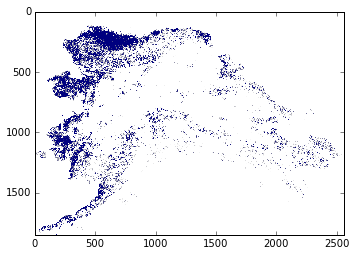

In [72]:
vt4 = np.where(lcdata==4, lcdata, np.nan)
plt.imshow(vt4)

Looks pretty good. Vegetation type "4" must be some kind of tundra?

## Apply mask to temperature

Next, we read in a temperature file and see what it takes to 
"apply" the mask to the temperature file.

First we notice that for some reason `numpy` and or `rasterio`
are not recognizing "NaN" values appropriately. So when we try to 
look at the temperature file to make sure we read it correctly, we
can't see anything because the color scale is being stretched 
over too large of a range:

<matplotlib.colorbar.Colorbar instance at 0x1638b1ea8>

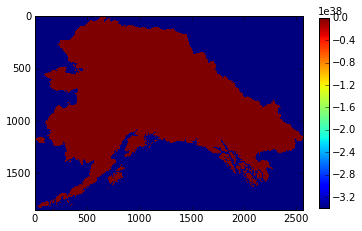

In [73]:
tfile = rasterio.open("../../snap-data/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_2001_2100/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_01_2001.tif")
tdata = tfile.read_band(1)

plt.imshow(tdata)
plt.colorbar(shrink=0.855)

In [74]:
print("Min:", tdata.min(), "Max:", tdata.max())

Min: -3.4e+38 Max: 2.79982


To fix this, we can mask off the pixels with extremely low values.
Seems like it should be same to assume that anything below -200
should be "NaN".

<matplotlib.colorbar.Colorbar instance at 0x1682ee8c0>

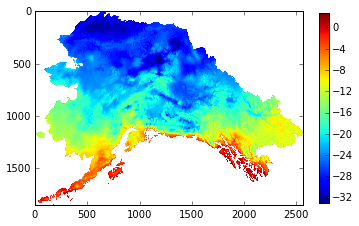

In [75]:
oktemp = np.where(tdata > -200, tdata, np.nan)

plt.imshow(oktemp)
plt.colorbar(shrink=0.855)

That looks pretty reasonable.

Now we want to try to apply the mask to the temperature data, 
effectively finding all the tempertature data for pixels/cells that
have a vegetation type number equal to 4. 

This is accomplished by taking advantage of numpy's array broadcasting
and behavior when performaing math on `np.nan` values. By adding and then 
subtracting the vegetation mask with the temperature data, we end up with 
only the temperature values where vegetation type is 4.

Not sure if this is the most efficient way to do it, but it works for
initial testing. Seems pretty decent though:

In [76]:
%time veg4_tempdata = vt4 + oktemp - vt4

CPU times: user 22.9 ms, sys: 5.37 ms, total: 28.3 ms
Wall time: 27.5 ms


<matplotlib.colorbar.Colorbar instance at 0x16aeae170>

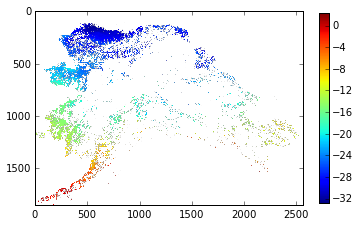

In [77]:
plt.imshow(veg4_tempdata)
plt.colorbar(shrink=0.855)

Looks pretty good. This is all the temperature data where 
vegetation type is 4. 

In [78]:
print(type(veg4_tempdata))
print("Min:", np.nanmin(veg4_tempdata), "Max:", np.nanmax(veg4_tempdata))

<type 'numpy.ndarray'>
Min: -32.8997917175 Max: 2.39927124977


## Create netcdf file

Now we will create a NetCDF file from this "masked" `veg4_tempdata` data array. We setup a function that:

 * Gets a netcdf file handle.
 * Creates dimensions big enough to accomodate the 
 mask (and images).
 * Creates an unlimited variable to read the data into.
 * Reads a bunch of files, assigning the contents to time-
 in the netcdf file.

In [79]:
def custom_file_masker(selected_mask, years=10):

    ncfile = netCDF4.Dataset('sample.nc', mode='w', format='NETCDF4')

    # Check on the shape
    #print selected_mask.shape

    Y = ncfile.createDimension('X', selected_mask.shape[1])
    X = ncfile.createDimension('Y', selected_mask.shape[0])
    time = ncfile.createDimension('time', None)

    tair = ncfile.createVariable('tair', np.float32, ('time','Y','X'))

    years = list(range(2001, 2001+years))
    print("Running custom file masker for %s years." % years)
    months = list(range(1,13))

    # open the file, read the band, deal with NaNs, mask it,
    # and append to the netcdf file
    for iy, year in enumerate(years):
        for im, month in enumerate(months):
            #print iy*12+im, "_%02i_%04i.tif" % (month, year)
            temperature_file = rasterio.open("../../snap-data/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_2001_2100/tas_mean_C_iem_cccma_cgcm3_1_sresa1b_%02i_%04i.tif" % (month, year))
            temp_data = temperature_file.read_band(1)
            oktemps = np.where(temp_data > -200, temp_data, np.nan)
            tempdata_for_vegnum = selected_mask + oktemps - selected_mask
            tair[iy*12+im,:,:] = tempdata_for_vegnum

    # make sure to close the file        
    ncfile.close()

Call our function and check up on the resulting file:

In [80]:
%time custom_file_masker(vt4, years=1)

# Check size
!ls -alh sample.nc | cut -d" " -f 7-

Running custom file masker for [2001] years.
CPU times: user 1.58 s, sys: 387 ms, total: 1.97 s
Wall time: 2.11 s
  217M Dec 19 09:37 sample.nc


In [81]:
%time custom_file_masker(vt4, years=5)

# Check size
!ls -alh sample.nc | cut -d" " -f 7-

Running custom file masker for [2001, 2002, 2003, 2004, 2005] years.
CPU times: user 7.8 s, sys: 1.69 s, total: 9.49 s
Wall time: 10 s
  1.1G Dec 19 09:37 sample.nc


In [82]:
%time custom_file_masker(vt4, years=10)

# Check size
!ls -alh sample.nc | cut -d" " -f 7-

Running custom file masker for [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010] years.
CPU times: user 15.3 s, sys: 3.28 s, total: 18.5 s
Wall time: 19.5 s
  2.1G Dec 19 09:38 sample.nc


In [83]:
!ncdump -h "sample.nc"

netcdf sample {
dimensions:
	X = 2560 ;
	Y = 1850 ;
	time = UNLIMITED ; // (120 currently)
variables:
	float tair(time, Y, X) ;
}


Takes about ~20 seconds and ~2.1GB for one variable, 10 years worth of data 

## Compress file

In [85]:
!nccopy -d2 "sample.nc" "sample-deflated.nc"

In [93]:
!ls -alh sample*.nc| cut -d" " -f 7-

   99M Dec 19 09:53 sample-deflated.nc
  2.1G Dec 19 09:38 sample.nc
